## Training of models that prodict insertions only from the the data of the two neighboring positions

In [19]:
#import packages
import pickle
import numpy as np
from Bio import SeqIO
from Bio.PDB import *
from Bio.PDB import PDBParser
import seaborn as sns 
from utils.plotting import *
from utils.processing import *
from utils.model import *
from Bio import SeqIO
import pickle
import scipy.stats
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn import linear_model

# set styles
plt.style.use('./utils/domain_ins.mplstyle')
plt.rcParams['svg.fonttype'] = 'none'

In [20]:
# define dirs
base = '/work/projects/project01640/jm/domain_insertion/DI_screen'
in_folder = f'{base}/analysis/input_data'
data_folder = f'{base}/analysis/output_datasets'
fig_folder = f'{base}/analysis/figures'
fasta_sequences = {rec.id : rec.seq for rec in SeqIO.parse(f'{in_folder}/proteins.fasta', 'fasta')}

# import data
with open(f'{data_folder}/proteins_training.pickle', 'rb') as input:
    full_dataset = pickle.load(input)
input.close()

with open(f'{data_folder}/analysis_dict.pickle', 'rb') as input:
    analysis_dict = pickle.load(input)
input.close()


# Classifiers

### Individual proteins

Binerize the output:

In [21]:
for name, protein in full_dataset.items():
    for key, dataset in protein.items():
        dataset.loc[dataset.log>0, 'log']= 1
        dataset.loc[dataset.log<=0, 'log'] = 0

Build classifier:

**AraC**

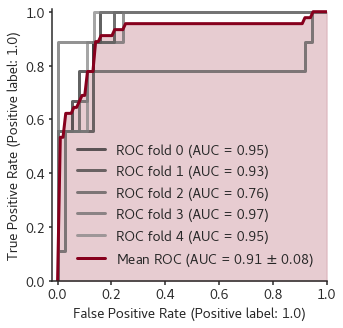

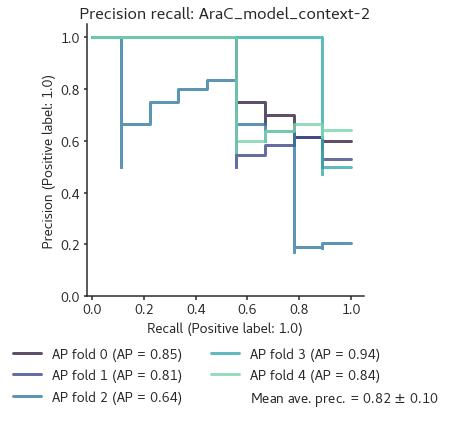

In [22]:
GBC = Classifier(full_dataset['AraC']['2'], n_cross_val=5, title_text='AraC_model_context-2')
GBC.encode_AA_sequences(fasta_sequences['AraC_s'])
GBC.encode_sec_structures()
del GBC.dataset['prox_AAs']
GBC.clf = GradientBoostingClassifier(n_estimators=150, criterion='friedman_mse', learning_rate=.2, subsample=1, max_depth=3, min_samples_split=4, max_features='sqrt', loss='exponential', random_state=42) 
model_AraC, X_test_AraC, y_test_AraC, X_train_AraC, y_train_AraC, scores, kf_Ara, scaler = GBC.split_and_train()
GBC.metrics()

**TVMV**

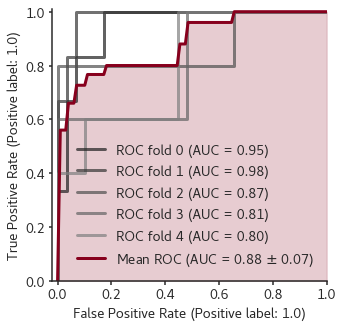

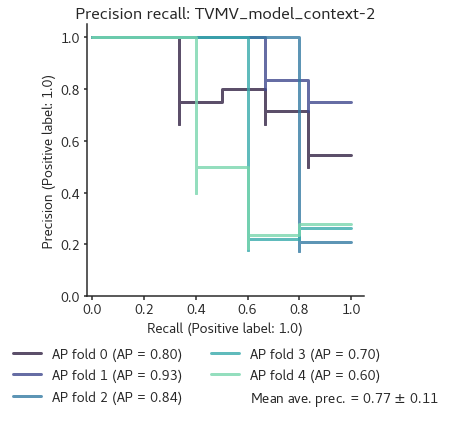

In [23]:
GBC = Classifier(full_dataset['TVMV']['2'], n_cross_val=5, title_text='TVMV_model_context-2')
GBC.encode_AA_sequences(fasta_sequences['TVMV_s'])
GBC.encode_sec_structures()
del GBC.dataset['prox_AAs']
model_TVMV, X_test_TVMV, y_test_TVMV, X_train_TVMV, y_train_TVMV, scores, kf_TVMV, scaler = GBC.split_and_train()
GBC.metrics()

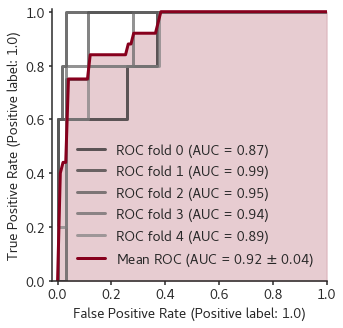

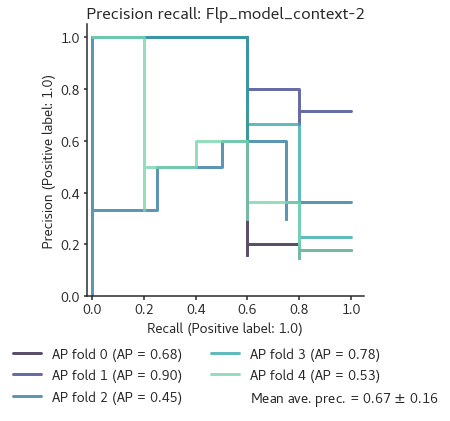

In [24]:
GBC = Classifier(full_dataset['Flp']['2'], n_cross_val=5, title_text='Flp_model_context-2')
GBC.encode_AA_sequences(fasta_sequences['Flp_s'])
GBC.encode_sec_structures()
del GBC.dataset['prox_AAs']
model_Flp, X_test_Flp, y_test_Flp, X_train_Flp, y_train_Flp, scores, kf_Flp, scaler = GBC.split_and_train()
GBC.metrics()

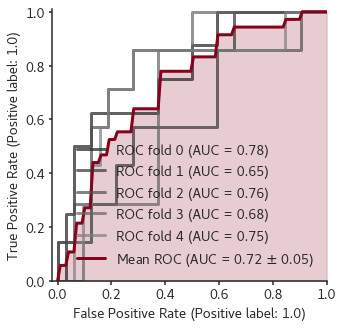

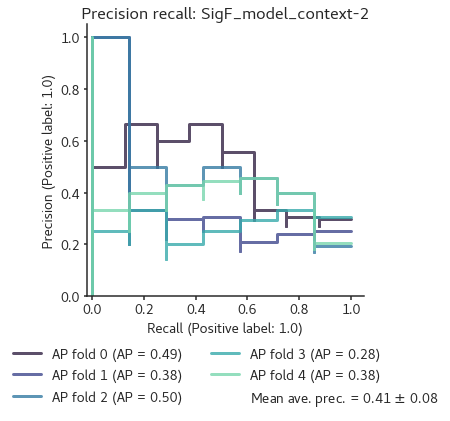

In [25]:
GBC = Classifier(full_dataset['SigF']['2'], n_cross_val=5, title_text='SigF_model_context-2')
GBC.encode_AA_sequences(fasta_sequences['SigF_s'])
GBC.encode_sec_structures()
del GBC.dataset['prox_AAs']
model_SigF, X_test_SigF, y_test_SigF, X_train_SigF, y_train_SigF, scores, kf_SigF, scaler = GBC.split_and_train()
GBC.metrics()

## Prepare complete dataset

Add output from transformer insertion model:

Combine datasets to on:

In [26]:
final_dataset = full_dataset['AraC'].copy()
fasta_sequences_concat = fasta_sequences['AraC_s'] + fasta_sequences['TVMV_s'] + fasta_sequences['Flp_s'] + fasta_sequences['SigF_s']
for protein in ['TVMV', 'Flp', 'SigF']:
    for idx, dataset in full_dataset[f'{protein}'].items():
        final_dataset[idx] = pd.concat([final_dataset[idx], dataset], axis=0)
        final_dataset[idx] = final_dataset[idx].reset_index()
        del final_dataset[idx]['prox_AAs']
        del final_dataset[idx]['index']

Train model:

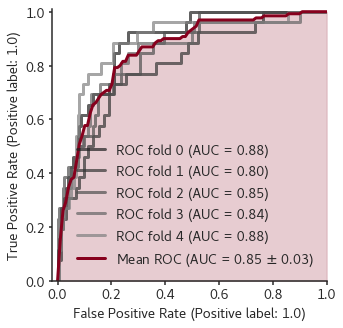

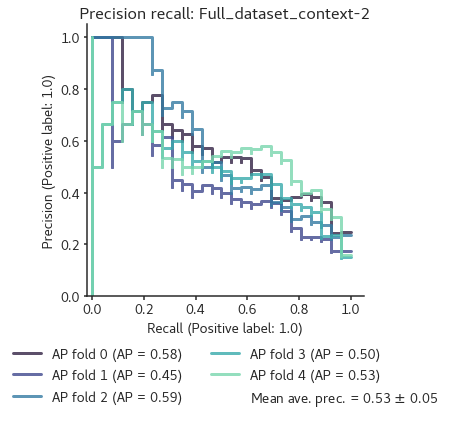

0.277

In [27]:
random_forest = Classifier(final_dataset['2'], n_cross_val=5, title_text='Full_dataset_context-2')
random_forest.encode_AA_sequences(fasta_sequences_concat)
random_forest.encode_sec_structures()
#random_forest.grid_search({"alpha": [.00001, .0001, .001], 'penalty':['l1'], 'tol':[1e-3, 5e-4, 1e-4]}, linear_model.Perceptron())
model_complete, X_test_complete, y_test_complete, X_train_complete, y_train_complete, scores_complete, kf_complete, scaler_complete = random_forest.split_and_train()
random_forest.metrics()
scores_complete['test_recall'].mean().round(3)

Train model on AA one-hot-encoding alone:

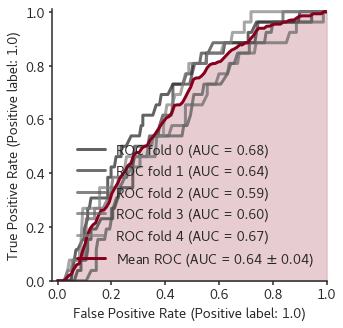

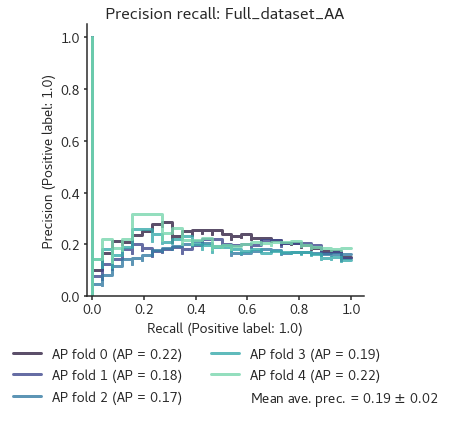

0.0

In [28]:
GBC_one_hot = Classifier(final_dataset['2']['log'], n_cross_val=5, title_text='Full_dataset_AA')
GBC_one_hot.encode_AA_sequences(fasta_sequences_concat)
model_AA, X_test_AA, y_test_AA, X_train_AA, y_train_AA, scores_AA, kf_AA, scaler_AA = GBC_one_hot.split_and_train()
GBC_one_hot.metrics()
scores_AA['test_recall'].mean().round(3)

### Analyze feature importance

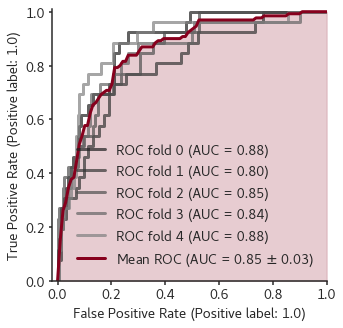

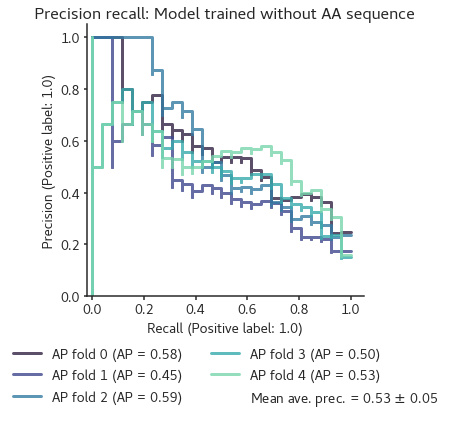

array([0.57563299, 0.45476524, 0.58578322, 0.49548324, 0.52716053])

In [40]:
GBC = Classifier(final_dataset['2'], n_cross_val=5, title_text='Model trained without AA sequence')
GBC.encode_AA_sequences(fasta_sequences_concat)
GBC.encode_sec_structures()
model_complete, X_test_complete, y_test_complete, X_train_complete, y_train_complete, scores_complete, kf_complete, scaler_complete = GBC.split_and_train()
GBC.metrics()
scores_complete['test_average_precision']

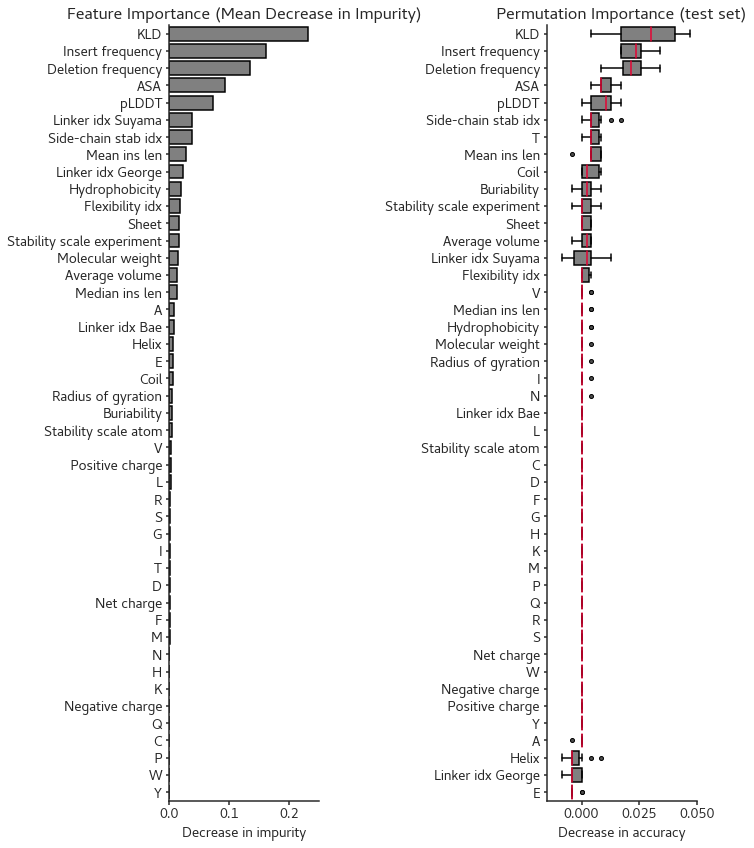

In [45]:
from sklearn.inspection import permutation_importance

GBC.clf.fit(X_train_complete, y_train_complete)
feature_importance = GBC.clf.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(10, 12))
plt.subplot(1, 2, 1)
data = pd.DataFrame([np.array(GBC.dataset.columns)[sorted_idx], feature_importance[sorted_idx]]).T
data.columns=['features', 'importance']
data.features = data.features.str.replace('_', ' ')
#plt.barh(pos, feature_importance[sorted_idx], align="center")
g = sns.barplot(data= data.iloc[::-1], y='features', x='importance', color='grey', linewidth=1.5, capsize=.2, errcolor="black", edgecolor="black")
g.set(xlim=(0, .25))
plt.ylabel('')
plt.xlabel('Decrease in impurity')
plt.title("Feature Importance (Mean Decrease in Impurity)")

result = permutation_importance(GBC.clf, X_test_complete, y_test_complete, n_repeats=10, random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
data = pd.DataFrame(result.importances[sorted_idx]) # TODO concat all columns
data.index = np.array(GBC.dataset.columns)[sorted_idx]
combined = data.stack()
combined = combined.reset_index(level=0)
combined.columns = ['features', 'value']
combined['features'] = combined['features'].str.replace('_', ' ')
plt.subplot(1, 2, 2)
g2 = sns.boxplot(data=combined.iloc[::-1], x='value', y='features', color='grey', fliersize=4, linewidth=1.5, whiskerprops={'color':'black'}, flierprops={"marker": "o", 'color':'black', 'linewidth':0, 'markeredgecolor':'black'}, 
capprops={'color':'black'}, boxprops={'color':'grey', 'linewidth':1.5, 'edgecolor':'black'}, medianprops={'color':'#E60234'})
g2.set(xlim=(-.015, .05))
plt.ylabel('')
plt.xlabel('Decrease in accuracy')

plt.title("Permutation Importance (test set)")
plt.subplots_adjust(hspace=.1, top=.5, bottom=0)
fig.tight_layout()
plt.savefig(f"{fig_folder}/Classifier_feature_importance.svg")
plt.show()

Train and assess reduced model:

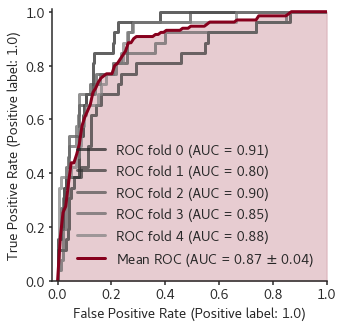

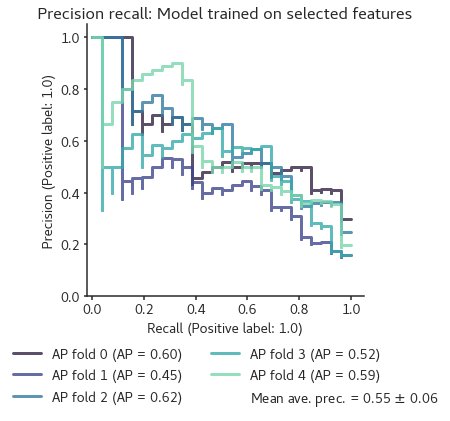

array([0.38461538, 0.30769231, 0.26923077, 0.38461538, 0.38461538])

In [48]:
# best performing combination
GBC_small = Classifier(final_dataset['2'][['log', 'pLDDT', 'Linker_idx_Suyama',
       'KLD', 'Insert_frequency','Deletion_frequency', 'Mean_ins_len']], n_cross_val=5, title_text='Model trained on selected features')
model_, X_test_, y_test_, X_train_, y_train_, scores_, kf_, scaler_ = GBC_small.split_and_train()
GBC_small.metrics()
scores_['test_recall']

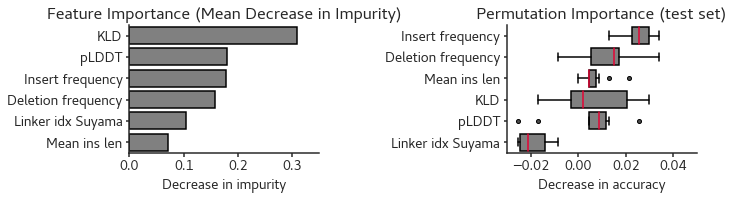

In [49]:

GBC_small.clf.fit(X_train_complete, y_train_complete)
feature_importance = random_forest.clf.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(10, 3))
plt.subplot(1, 2, 1)
data = pd.DataFrame([np.array(random_forest.dataset.columns)[sorted_idx], feature_importance[sorted_idx]]).T
data.columns=['features', 'importance']
data.features = data.features.str.replace('_', ' ')
#plt.barh(pos, feature_importance[sorted_idx], align="center")
g = sns.barplot(data= data.iloc[::-1], y='features', x='importance', color='grey', linewidth=1.5, capsize=.2, errcolor="black", edgecolor="black")
g.set(xlim=(0, .35))
plt.ylabel('')
plt.xlabel('Decrease in impurity')
plt.title("Feature Importance (Mean Decrease in Impurity)")

result = permutation_importance(random_forest.clf, X_test_, y_test_, n_repeats=10, random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
data = pd.DataFrame(result.importances[sorted_idx]) # TODO concat all columns
data.index = np.array(random_forest.dataset.columns)[sorted_idx]
combined = data.stack()
combined = combined.reset_index(level=0)
combined.columns = ['features', 'value']
combined['features'] = combined['features'].str.replace('_', ' ')
plt.subplot(1, 2, 2)
g2 = sns.boxplot(data=combined.iloc[::-1], x='value', y='features', color='grey', fliersize=4, linewidth=1.5, whiskerprops={'color':'black'}, flierprops={"marker": "o", 'color':'black', 'linewidth':0, 'markeredgecolor':'black'}, 
capprops={'color':'black'}, boxprops={'color':'grey', 'linewidth':1.5, 'edgecolor':'black'}, medianprops={'color':'#E60234'})
g2.set(xlim=(-.03, .05))
plt.ylabel('')
plt.xlabel('Decrease in accuracy')

plt.title("Permutation Importance (test set)")
plt.subplots_adjust(hspace=.1, top=.5, bottom=0)
fig.tight_layout()
plt.savefig(f"{fig_folder}/Classifier_feature_importance_less_features.svg")
plt.show()

## Baselines

In [55]:

model_predictions = model_complete.predict_proba(X_test_complete)
model_predictions = model_predictions[:,1]
random_baseline = np.random.randint(2, size=len(X_test_complete))
loops_baseline = X_test_complete[:,0]
asa_baseline = X_test_complete[:,23]
hydrophobicity_baseline = X_test_complete[:,28]
baseline_auroc = []
baseline_pr = []
for idx, mod in enumerate([model_predictions, random_baseline, loops_baseline, asa_baseline, hydrophobicity_baseline]):
    baseline_auroc.append(metrics.roc_auc_score(y_test_complete, mod)) 
    baseline_pr.append(metrics.average_precision_score(y_test_complete, mod))

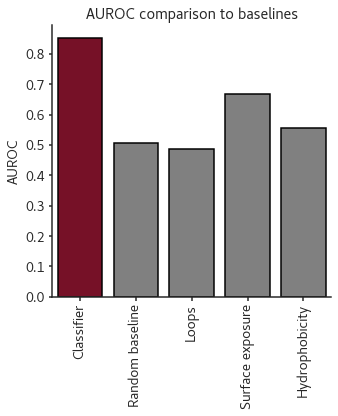

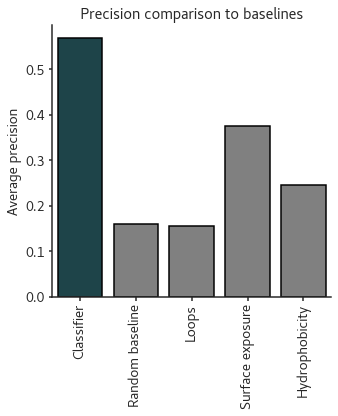

[0.852791878172589, 0.5071340375908904, 0.4860749073947044, 0.6692276032377557, 0.5543284401152422]
[0.5690259769934704, 0.16006006006006007, 0.15459230503478294, 0.37613268789585536, 0.24472961031516038]


In [56]:
names = ['Classifier', 'Random baseline', 'Loops', 'Surface exposure', 'Hydrophobicity']
fig = plt.figure(figsize=(5,5))
g = sns.barplot(x=names, y=baseline_auroc, palette=['#87001D', 'grey', 'grey', 'grey', 'grey'], linewidth=1.5, capsize=.2, errcolor="black", edgecolor="black")
g.set_xticklabels(names, rotation=90)
g.set(ylabel='AUROC')
g.set_title(label='AUROC comparison to baselines', fontsize=15)
plt.savefig(f"{fig_folder}/baselines_auroc.svg")
plt.show()

fig = plt.figure(figsize=(5,5))
g = sns.barplot(x=names, y=baseline_pr, palette=['#174950', 'grey', 'grey', 'grey', 'grey'], linewidth=1.5, capsize=.2, errcolor="black", edgecolor="black")
g.set_xticklabels(names, rotation=90)
g.set(ylabel='Average precision')
g.set_title(label='Precision comparison to baselines', fontsize=15)
plt.savefig(f"{fig_folder}/baselines_ap.svg")
plt.show()
print(baseline_auroc)
print(baseline_pr)

In [57]:

model_predictions = model_complete.predict_proba(X_test_complete)
model_predictions = model_predictions[:,1]
test_data_concat = np.c_[model_predictions, X_test_complete]
baseline_auroc = []
baseline_pr = []
for idx in range(test_data_concat.shape[1]):
    baseline_auroc.append(metrics.roc_auc_score(y_test_complete, test_data_concat[:,idx])) 
    baseline_pr.append(metrics.average_precision_score(y_test_complete, test_data_concat[:,idx]))

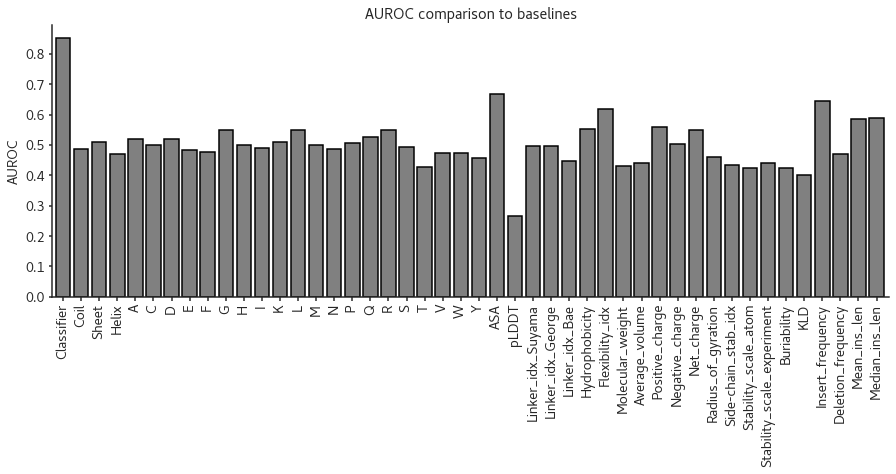

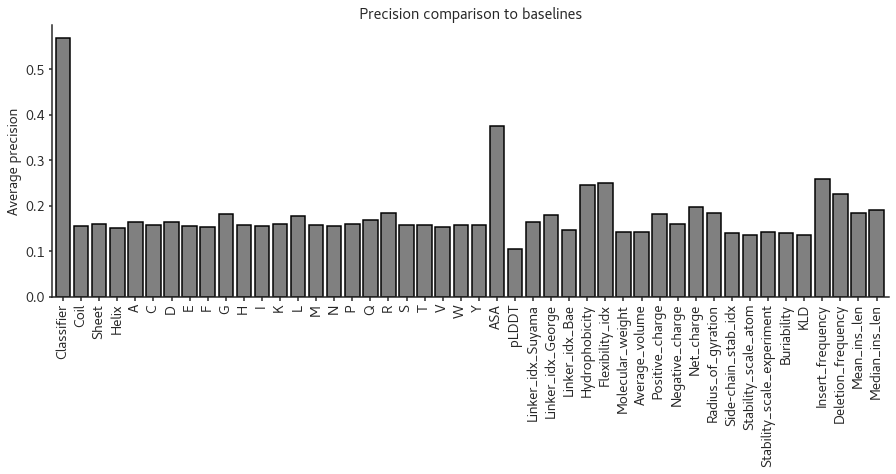

In [59]:
names = ['Classifier'] + GBC.dataset.columns.to_list()

fig = plt.figure(figsize=(15,5))
g = sns.barplot(x=names, y=baseline_auroc, color='grey', linewidth=1.5, capsize=.2, errcolor="black", edgecolor="black")
g.set_xticklabels(names, rotation=90)
g.set(ylabel='AUROC')
g.set_title(label='AUROC comparison to baselines', fontsize=15)
g.set(xlim=(-.6, 45.7))
plt.savefig(f"{fig_folder}/baselines_auroc_full.svg")
plt.show()

fig = plt.figure(figsize=(15,5))
g = sns.barplot(x=names, y=baseline_pr, color='grey', linewidth=1.5, capsize=.2, errcolor="black", edgecolor="black")
g.set_xticklabels(names, rotation=90)
g.set(ylabel='Average precision')
g.set_title(label='Precision comparison to baselines', fontsize=15)
plt.savefig(f"{fig_folder}/baselines_ap_full.svg")
g.set(xlim=(-.6, 45.7))
plt.show()